# Error Backpropagation

The purpose of this notebook is to implement the error backpropagation algorithm. We will implement the backpropagation algorithm and a 1-D convolution in numpy.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Error Backpropagation

In this section we will practice implementing the backpropagation algorithm to compute gradients for an MLP with a single hidden layer, and train the model by applying the computed gradients with a network optimiser.

we will use the [QSAR fish toxicity dataset](https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity) from the UCI machine learning repository.

We will start by loading this dataset.

In [2]:
# Load the data from CSV

data = pd.read_csv('qsar_fish_toxicity.csv', sep=';', header=None)
x = data.iloc[:, :6]  ## <-- inputs
y = data.iloc[:, 6:]  ## <-- targets

In [3]:
# Create training and validation splits

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [4]:
# Standardise the inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
# Load the data into Dataset objects

train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_data = train_data.shuffle(1202)
train_data = train_data.batch(128)

test_data = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))
test_data = test_data.batch(128)

train_data.element_spec

(TensorSpec(shape=(None, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

We will use an MLP model with a single hidden layer with 64 neurons, and a tanh activation function. The output layer has 1 neuron and no activation function.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='tanh', input_shape=(6,)),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='mse')
model.evaluate(test_data)

2/2 [==============================] - 0s 6ms/step - loss: 18.3333


18.33327865600586

This MLP model has two kernel variables and two bias variables.

In [8]:
W0 = model.layers[0].kernel
b0 = model.layers[0].bias

W1 = model.layers[1].kernel
b1 = model.layers[1].bias

In [9]:
W0.shape

TensorShape([6, 64])

In [10]:
W1.shape

TensorShape([64, 1])

we will implement the forward and backward pass of backpropagation manually.

The following function implements the dense layer transformation to obtain the pre-activation values.

In [11]:
def dense(h, W, b):
    
    # h: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    return b + h @ W

 the backpropagation algorithm can be summarised as follows:

>1. Define the **error** $\delta^{(k)}_p := \frac{\partial \mathcal{L}_i}{\partial a^{(k)}_p}$ for layer $k$, where we denote $\mathcal{L}_i$ as the loss for example $i$, and $a^{(k)}_p$ is the $p$-th pre-activation in layer $k$
>2. Propagate the signal forwards by passing an input vector $x_i$ through the network and computing all pre-activations and post-activations using $\mathbf{a}^{(k)} = (\boldsymbol{h}^{(k-1)})^T\boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)}$
> 3. Evaluate $\boldsymbol{\delta}^{(L+1)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(L+1)}}$ for the output neurons
> 4. Backpropagate the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\boldsymbol{\delta}^{(k)} = \boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})  \boldsymbol{W}^{(k)} \boldsymbol{\delta}^{(k+1)}$
> 5. Obtain the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$

In the above, $\boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})$ is a diagonal matrix with diagonal elements $\sigma'(a^{(k)}_p)$, $p=1,\ldots,n_k$, where $n_k$ is the number of neurons in hidden layer $k$.

In our case, we have an MLP with one hidden layer ($L=1$). The loss $\mathcal{L}_i$ for data example $(x_i, y_i)$ will be the mean squared error

$$
\mathcal{L}_i = \frac{1}{2}(y_i - f(x_i))^2,
$$

where $f:\mathbb{R}^6\mapsto\mathbb{R}$ is the MLP network.

We will start by computing the output error $\boldsymbol{\delta}^{(2)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(2)}}$.

In [12]:
def output_error(y_batch, a2):
    
    # y_batch: K x 1 array of data outputs
    # a2: K x 1 array of output pre-activations
    # returns: K x 1 array of output errors 
    
    return a2 - y_batch

We will also need to compute the diagonal matrix $\boldsymbol{\sigma}'(\boldsymbol{a}^{(1)})$:

In [13]:

def activation_derivative(a1):
    
    # a1: K x 64 array of hidden layer pre-activations
    # returns: K x 64 array of diagonal elements  
    
    return 1 - np.square(np.tanh(a1)) # dtanh(x)/dx = 1 - tanh(x)^2

Given the output error $\boldsymbol{\delta}^{(2)}$, kernel matrix $\boldsymbol{W}^{(1)}$ and the preactivations $\boldsymbol a^{(1)}$, we need to backpropagate the error $\boldsymbol{\delta}^{(2)}$ to get $\boldsymbol{\delta}^{(1)}$.

In [14]:
def backpropagate(delta2, W1, a1):
    
    # delta2: K x 1 array of output errors
    # W1: 64 x 1 array
    # a1: K x 64 array of hidden layer pre-activations
    # returns: K x 64 array of hidden layer errors
    # K here is the minibatch size, hence we are applying the backpropagation formula 
    # for each sample in the mini-batch (this is why we use the element-wise product)  
    
    return np.squeeze(activation_derivative(a1)[..., np.newaxis] * W1 * delta2[:, np.newaxis, :])

Finally, given the errors $\boldsymbol{\delta}^{(1)}$ and $\boldsymbol{\delta}^{(2)}$ and post-activations $\boldsymbol{h}^{(0)}$ ($=\boldsymbol{x}$) and $\boldsymbol{h}^{(1)}$, we can compute the gradients $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(0)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(0)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(1)}}$ and $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(1)}}$.

The function below should compute these gradients, averaged over the batch size.

In [15]:
def grads(delta1, delta2, h0, h1):
    
    # delta1: K x 64 array of hidden layer errors
    # delta2: K x 1 array of output errors
    # h0: K x 6 array of inputs
    # h1: K x 64 array of hidden layer post-activations
    # returns: tuple of arrays of shape (6 x 64), (64,), (64 x 1), (1,) for gradients
    
    grad_W0 = delta1[:, np.newaxis, :] * h0[:, :, np.newaxis] # dimension (128,6,64)
    grad_b0 = delta1
    grad_W1 = delta2[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b1 = delta2
    
    grad_W0 = tf.reduce_mean(grad_W0, axis=0) # dimension (6,64)
    grad_b0 = tf.reduce_mean(grad_b0, axis=0)
    grad_W1 = tf.reduce_mean(grad_W1, axis=0)
    grad_b1 = tf.reduce_mean(grad_b1, axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1

We now have what we need to compute the gradients in order to train the model using a network optimiser.

The code below will run the training loop using your functions above, and apply the gradients using an RMSprop optimizer.

In [16]:
# Run the training loop

epochs = 100
best_val_loss = np.inf
rmsprop = tf.keras.optimizers.RMSprop()

losses = []

for epoch in range(epochs):
    for x_batch, y_batch in train_data:
        losses.append(tf.reduce_mean(tf.keras.losses.mse(y_batch, model(x_batch))).numpy())
        
        a1 = dense(x_batch, W0, b0)
        h1 = np.tanh(a1)
        a2 = dense(h1, W1, b1)
        
        delta2 = output_error(y_batch, a2)
        delta1 = backpropagate(delta2, W1, a1)
        
        var_grads = grads(delta1, delta2, x_batch, h1)
        
        rmsprop.apply_gradients(zip(var_grads, [W0, b0, W1, b1]))

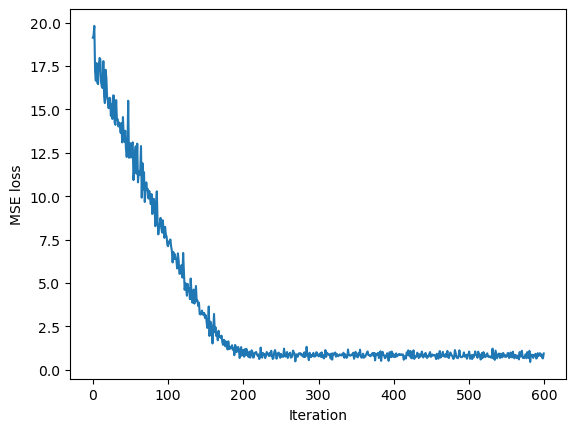

In [17]:
# Plot the learning curve

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.show()

In [18]:
# Evaluate the model on the test dataset

model.compile(loss='mse')
model.evaluate(test_data)

2/2 [==============================] - 0s 4ms/step - loss: 1.0415


1.0415217876434326